# Grammianos ponderados entre subespacios ligand-free (lf), ligand-bound (lb) y subespacios de la dinámica de no equilibrio

In [2]:
using DataFrames
using Gadfly
using Cairo
using Distributions
set_default_plot_size(40cm, 14cm)

In [3]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [4]:
function read_ptraj_modes(file, modes_elements, nmodes::Int64=0, norma::Bool=true)    

    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    comments=true, comment_char='\*')
    close(modes_file)

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 3 methods)

In [5]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        temp_bool = (in_vec .>= in_bins[i]) & (in_vec .< in_bins[i+1])
        out_counts[i] = sum(in_weight[temp_bool])
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

In [6]:
function qgrammian0(mtx_1, mtx_2, weight_1 = 0)
    # Projects mtx_1 onto mtx_2 and gets the mean of the elements in the diagonal.
    if size(mtx_1)[1] != size(mtx_2)[1]
        println("Length of matrices columns must be the same. Aborting.")
        return 0
    end
    
    mtx_g = transpose(mtx_1) * mtx_2 * transpose(mtx_2) * mtx_1
      
    if weight_1 != 0
        # Weights were specified
        if length(weight_1) != size(mtx_1)[2]
            println("There must be as many weights as columns. Aborting.")
            return 0
        end
        weighted = diag(mtx_g) .* weight_1
        zeta = sum(weighted)
    else
        zeta = mean(diag(mtx_g))   
    end
    
    
    return zeta
end

qgrammian0 (generic function with 2 methods)

In [7]:
function qgrammian1(mtx_1, mtx_2, weight_1 = 0, weight_2 = 0)
    # Projects mtx_1 onto mtx_2 and gets the mean of the elements in the diagonal.
    if size(mtx_1)[1] != size(mtx_2)[1]
        println("Length of matrices columns must be the same. Aborting.")
        return 0
    end
    
    if weight_1 != 0 && weight_2 != 0
        # Weights were specified
        if length(weight_1) != size(mtx_1)[2] || length(weight_2) != size(mtx_2)[2]
            println("There must be as many weights as columns. Aborting.")
            return 0
        end
        mtx_1 = mtx_1 * diagm(weight_1)
        mtx_2 = mtx_2 * diagm(weight_2)
    end
    
    mtx_g = transpose(mtx_1) * mtx_2 * transpose(mtx_2) * mtx_1
    zeta = mean(diag(mtx_g))
    
    return zeta
end

qgrammian1 (generic function with 3 methods)

In [8]:
function grammian(mtx_1, mtx_2, weight_1 = 0, weight_2 = 0)
mtx_1 = lf_modes
mtx_2 = lb_modes
weight_1 = 0
weight_2 = 0

    # Projects mtx_1 onto mtx_2 and gets the mean of the elements in the diagonal.
    if size(mtx_1)[1] != size(mtx_2)[1]
        println("Length of matrices columns must be the same. Aborting.")
        return 0
    end
    
    if weight_1 != 0 && weight_2 != 0
        # Weights were specified
        if length(weight_1) != size(mtx_1)[2] || length(weight_2) != size(mtx_2)[2]
            println("There must be as many weights as columns. Aborting.")
            return 0
        end
        mtx_1 = mtx_1 * diagm(weight_1)
        mtx_2 = mtx_2 * diagm(weight_2)
    end
    
    mtx_p = transpose(mtx_1) * mtx_2 * transpose(mtx_2) * mtx_1
    eival, eivec = eig(mtx_g)
    
    return mean(eival)
end

grammian (generic function with 3 methods)

### Hago

In [9]:
# Preparo variables
aa = 101
aa3 = aa * 3
aa3_6 = aa3 - 6
n_frames = 400
boot_count = 800
main_dir = "/home/german/labo/16/pdz_gramm/"
LfLb_dir = "analyze_qha_ca/"
neq_dir = "lb_dats/"
neq_modes_dir = "vecs/"
boot_dir= "boot_mtces/"
rtdos_dir = "rtdos_log/"

neq_pond_template = "-lbnoteq_ca_mode_freq_nohist.dat"       # ej: "1" * neq_pond_template
neq_subspSize_template = "-lbnoteq_ca_subspace_countk.dat"   # ej: "1" * neq_subspSize_template
neq_modes_template = "lb_prod_vecs_ca_"                      # ej: neq_modes_template * "1" * ".dat"

# Leo indices de los modos de los subespacios ligand free y bound
lf_indices = readdlm(string(main_dir, LfLb_dir, "lf_prod_ca_subspace_countk.dat"));
lf_indices = convert(Array{Int64,1}, reshape(lf_indices, length(lf_indices)))
lf_indices = sort(lf_indices)
lb_indices = readdlm(string(main_dir, LfLb_dir, "lb_prod_ca_subspace_countk.dat"));
lb_indices = convert(Array{Int64,1}, reshape(lb_indices, length(lb_indices)))
lb_indices = sort(lb_indices)

# Leo y normalizo los pesos de los modos lf y lb
lf_pond = readdlm(string(main_dir, LfLb_dir, "lf_prod_ca_mode_freq_nohist.dat"))[lf_indices, 2]
lf_pond = lf_pond / sum(lf_pond)
lb_pond = readdlm(string(main_dir, LfLb_dir, "lb_prod_ca_mode_freq_nohist.dat"))[lb_indices, 2]
lb_pond = lb_pond / sum(lb_pond)

# Leo modos lf y lb
# lf
lf_modes, lf_eigen = read_ptraj_modes(string(main_dir, LfLb_dir, "lf_prod_vecs_ca.dat"), aa3, aa3_6)
lf_modes = lf_modes[:, lf_indices]
lf_eigen = lf_eigen[lf_indices]
# lb
lb_modes, lb_eigen = read_ptraj_modes(string(main_dir, LfLb_dir, "lb_prod_vecs_ca.dat"), aa3, aa3_6)
lb_modes = lb_modes[:, lb_indices]
lb_eigen = lb_eigen[lb_indices];

In [10]:
gramm_lf_neq = Array{Float64, 1}(n_frames)
gramm_lb_neq = Array{Float64, 1}(n_frames)
Wgramm_lf_neq = Array{Float64, 1}(n_frames)
Wgramm_lb_neq = Array{Float64, 1}(n_frames)
WWgramm_lf_neq = Array{Float64, 1}(n_frames)
WWgramm_lb_neq = Array{Float64, 1}(n_frames)
neq_modes_list = Array{Array{Float64, 2}, 1}(n_frames)
neq_eigen_list = Array{Array{Float64, 1}, 1}(n_frames)
neq_pond_list = Array{Array{Float64, 1}, 1}(n_frames)

for i in 1:n_frames
    pond_file = open(string(main_dir, neq_dir, i, neq_pond_template), "r")
    indices_file = open(string(main_dir, neq_dir, i, neq_subspSize_template), "r")
    modes_filename = string(main_dir, neq_modes_dir, neq_modes_template, i, ".dat")

    # Get the indices of the modes of the current subspace
    neq_indices = readdlm(indices_file);
    neq_indices = convert(Array{Int64,1}, reshape(neq_indices, length(neq_indices)))
    neq_indices = sort(neq_indices)

    # Get the coefficients for the ponderation
    neq_pond = readdlm(pond_file)[neq_indices, 2];
    neq_pond = neq_pond / sum(neq_pond)

    # Get the modes/eigenvalues of the current subspace
    neq_modes, neq_eigen = read_ptraj_modes(modes_filename, aa3)
    neq_modes = neq_modes[:, neq_indices]
    neq_eigen = neq_eigen[neq_indices]

    # Store the current modes, eigenvalues and weights
    neq_modes_list[i] = neq_modes
    neq_eigen_list[i] = neq_eigen
    neq_pond_list[i] = neq_pond
    
    # Grammiano
    gramm_lf_neq[i] = qgrammian0(neq_modes, lf_modes)
    gramm_lb_neq[i] = qgrammian0(neq_modes, lb_modes)
    
    # Grammiano ponderado
    Wgramm_lf_neq[i] = qgrammian1(neq_modes, lf_modes, neq_pond, lf_pond)
    Wgramm_lb_neq[i] = qgrammian1(neq_modes, lb_modes, neq_pond, lb_pond)
    
    # Verdadera ponderación 
    WWgramm_lf_neq[i] = qgrammian0(neq_modes, lf_modes, neq_pond)
    WWgramm_lb_neq[i] = qgrammian0(neq_modes, lb_modes, neq_pond)
end

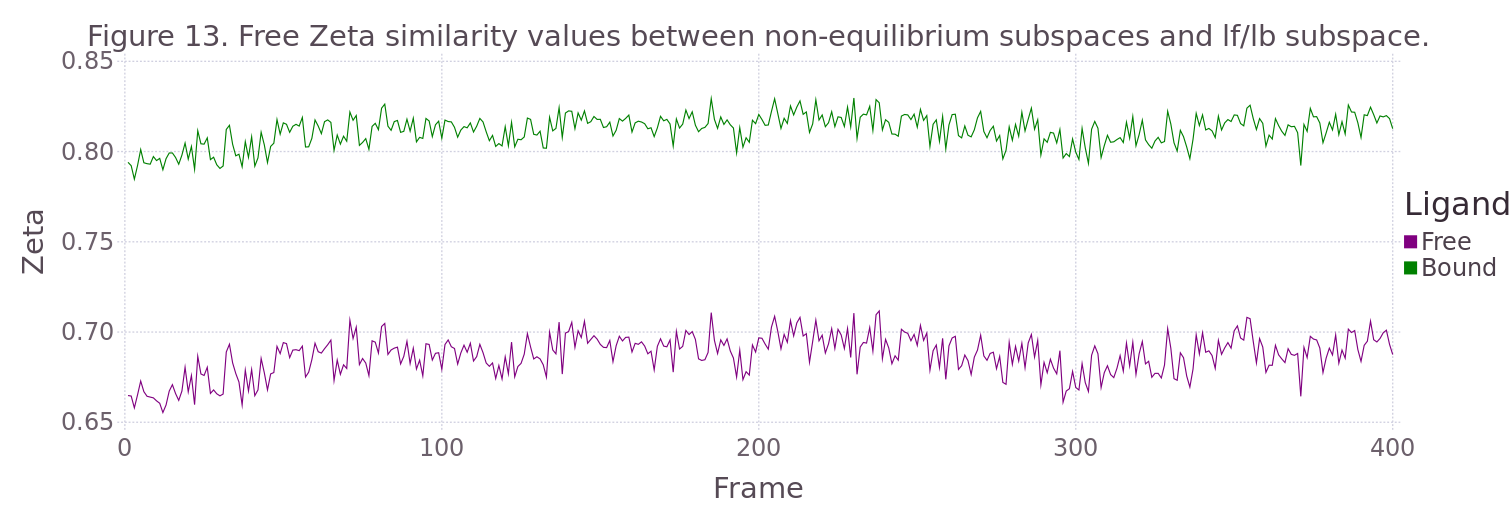

In [11]:
# Compila todo en un dataframe
df_gramm_neq_lf_lb = DataFrame(Zeta = [ gramm_lf_neq; gramm_lb_neq ], Ligand = repeat(["Free"; "Bound"], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames)])

# Plot
pdf_gramm_neq_lf_lb = plot(df_gramm_neq_lf_lb, x="Frame", y="Zeta", color = "Ligand", Geom.line,
Guide.title("Figure 13. Free Zeta similarity values between non-equilibrium subspaces and lf/lb subspace."),
Scale.color_discrete_manual(colorant"purple", colorant"green"),
Theme(grid_line_width=1pt, 
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

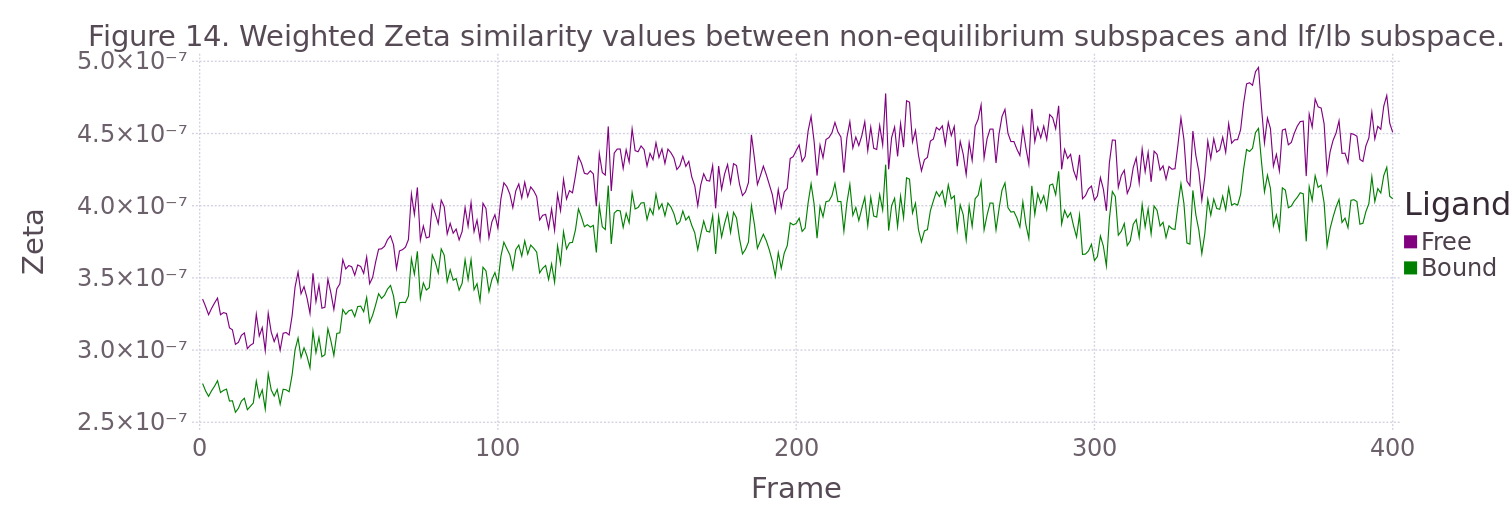

In [12]:
# Compila todo en un dataframe
df_Wgramm_neq_lf_lb = DataFrame(Zeta = [ Wgramm_lf_neq; Wgramm_lb_neq ], Ligand = repeat(["Free"; "Bound"], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames)])

# Plot
pdf_Wgramm_neq_lf_lb = plot(df_Wgramm_neq_lf_lb, x="Frame", y="Zeta", color = "Ligand", Geom.line,
Guide.title("Figure 14. Weighted Zeta similarity values between non-equilibrium subspaces and lf/lb subspace."),
Scale.color_discrete_manual(colorant"purple", colorant"green"),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

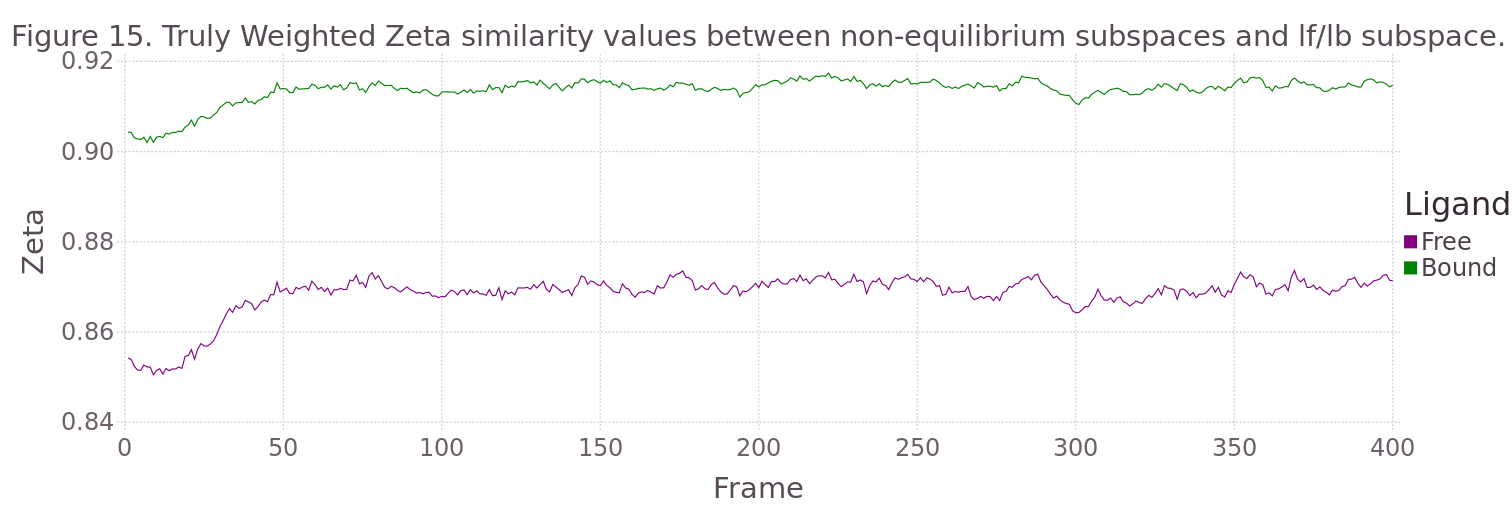

In [107]:
# Compila todo en un dataframe
df_WWgramm_neq_lf_lb = DataFrame(Zeta = [ WWgramm_lf_neq; WWgramm_lb_neq ], Ligand = repeat(["Free"; "Bound"], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames)])

# Plot
pdf_Wgramm_neq_lf_lb = plot(df_WWgramm_neq_lf_lb, x="Frame", y="Zeta", color = "Ligand", Geom.line,
Guide.title("Figure 15. Truly Weighted Zeta similarity values between non-equilibrium subspaces and lf/lb subspace."),
Scale.color_discrete_manual(colorant"purple", colorant"green"),
Guide.xticks(ticks=collect(0:50:400)),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

## Checkeo los valores de las ponderaciones de modos a lo largo de los frames. 

In [94]:
# Obtengo las variaciones de los 100 primeros modos en 100 arrays distintos
for i in 1:100
    mode_symbol = Symbol("PondMode_", i)
    @eval $mode_symbol = Array{Float64, 1}(n_frames)
    for j in 1:n_frames
        @eval $mode_symbol[j] = $neq_pond_list[j][i]
    end
end

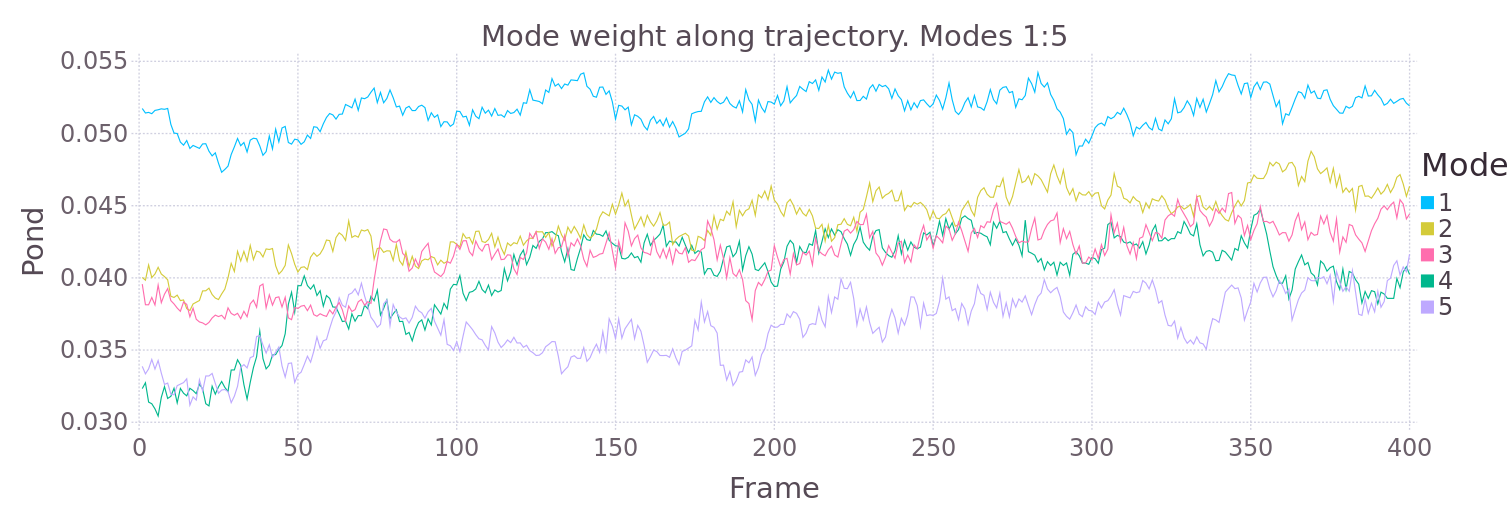

In [111]:
# Compila todo en un dataframe
df_PondMode = DataFrame(Pond = [ PondMode_1; PondMode_2; PondMode_3; PondMode_4; PondMode_5 ],
Mode = repeat(["1"; "2" ; "3"; "4" ; "5" ], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames) ; collect(1:n_frames) ;
    collect(1:n_frames) ; collect(1:n_frames) ])

# Plot
pdf_Wgramm_neq_lf_lb = plot(df_PondMode, x="Frame", y="Pond", color = "Mode", Geom.line,
Guide.title("Mode weight along trajectory. Modes 1:5"),
Guide.xticks(ticks=collect(0:50:400)),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

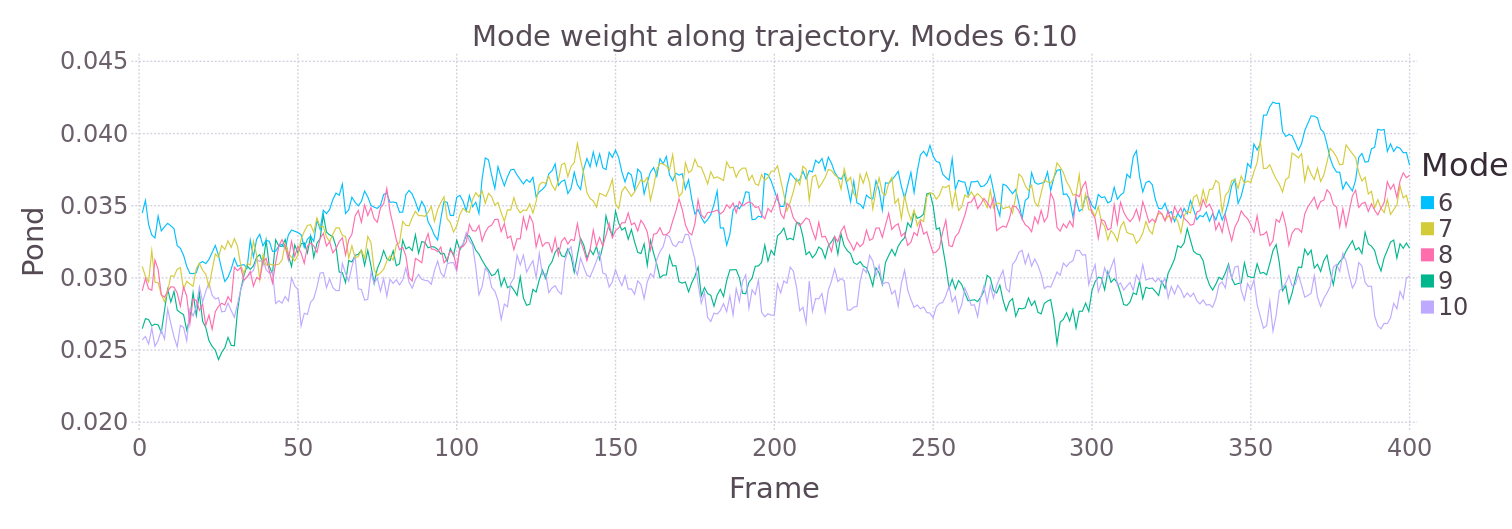

In [108]:
# Compila todo en un dataframe
df_PondMode = DataFrame(Pond = [ PondMode_6; PondMode_7; PondMode_8; PondMode_9; PondMode_10 ],
Mode = repeat(["6"; "7" ; "8"; "9" ; "10" ], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames) ; collect(1:n_frames) ;
    collect(1:n_frames) ; collect(1:n_frames) ])

# Plot
pdf_Wgramm_neq_lf_lb = plot(df_PondMode, x="Frame", y="Pond", color = "Mode", Geom.line,
Guide.title("Mode weight along trajectory. Modes 6:10"),
Guide.xticks(ticks=collect(0:50:400)),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

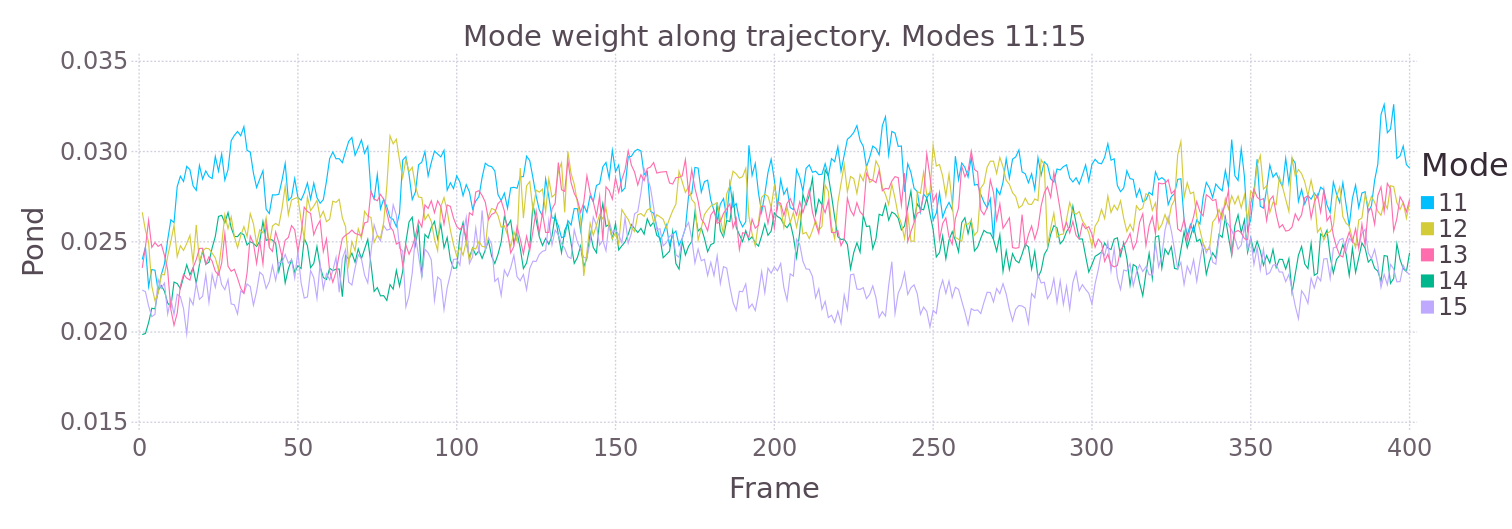

In [109]:
# Compila todo en un dataframe
df_PondMode = DataFrame(Pond = [ PondMode_11; PondMode_12; PondMode_13; PondMode_14; PondMode_15 ],
Mode = repeat(["11"; "12" ; "13"; "14" ; "15" ], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames) ; collect(1:n_frames) ;
    collect(1:n_frames) ; collect(1:n_frames) ])

# Plot
pdf_Wgramm_neq_lf_lb = plot(df_PondMode, x="Frame", y="Pond", color = "Mode", Geom.line,
Guide.title("Mode weight along trajectory. Modes 11:15"),
Guide.xticks(ticks=collect(0:50:400)),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

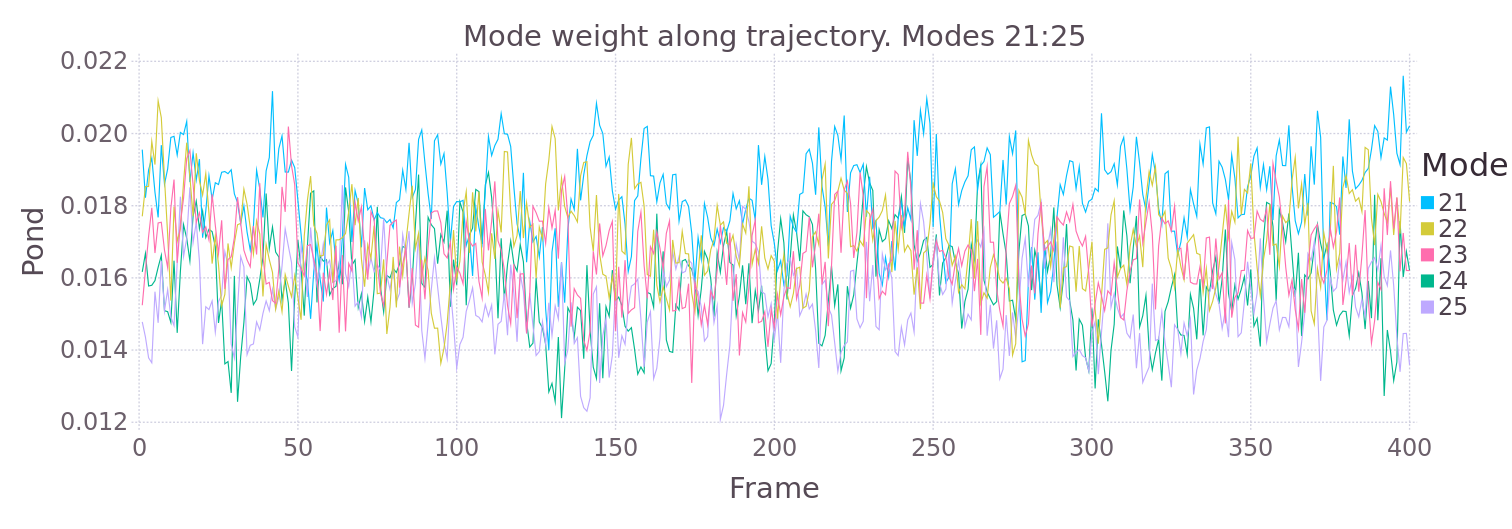

In [110]:
# Compila todo en un dataframe
df_PondMode = DataFrame(Pond = [ PondMode_21; PondMode_22; PondMode_23; PondMode_24; PondMode_25 ],
Mode = repeat(["21"; "22" ; "23"; "24" ; "25" ], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames) ; collect(1:n_frames) ;
    collect(1:n_frames) ; collect(1:n_frames) ])

# Plot
pdf_Wgramm_neq_lf_lb = plot(df_PondMode, x="Frame", y="Pond", color = "Mode", Geom.line,
Guide.title("Mode weight along trajectory. Modes 21:25"),
Guide.xticks(ticks=collect(0:50:400)),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

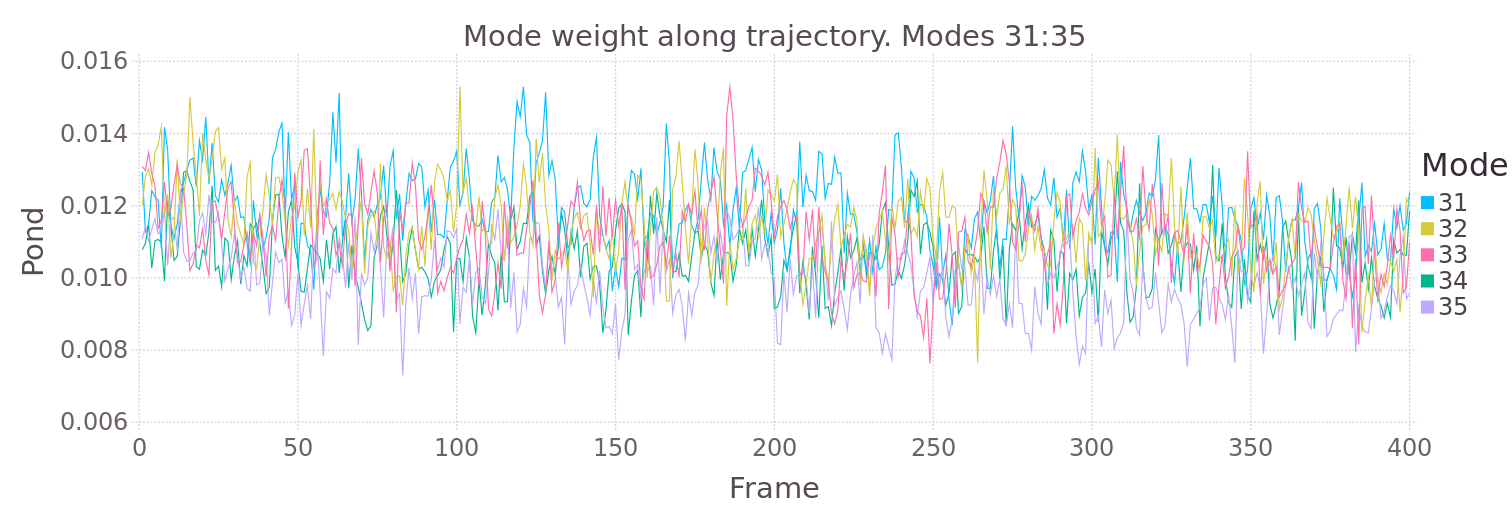

In [115]:
# Compila todo en un dataframe
df_PondMode = DataFrame(Pond = [ PondMode_31; PondMode_32; PondMode_33; PondMode_34; PondMode_35 ],
Mode = repeat(["31"; "32" ; "33"; "34" ; "35" ], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames) ; collect(1:n_frames) ;
    collect(1:n_frames) ; collect(1:n_frames) ])

# Plot
pdf_Wgramm_neq_lf_lb = plot(df_PondMode, x="Frame", y="Pond", color = "Mode", Geom.line,
Guide.title("Mode weight along trajectory. Modes 31:35"),
Guide.xticks(ticks=collect(0:50:400)),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))


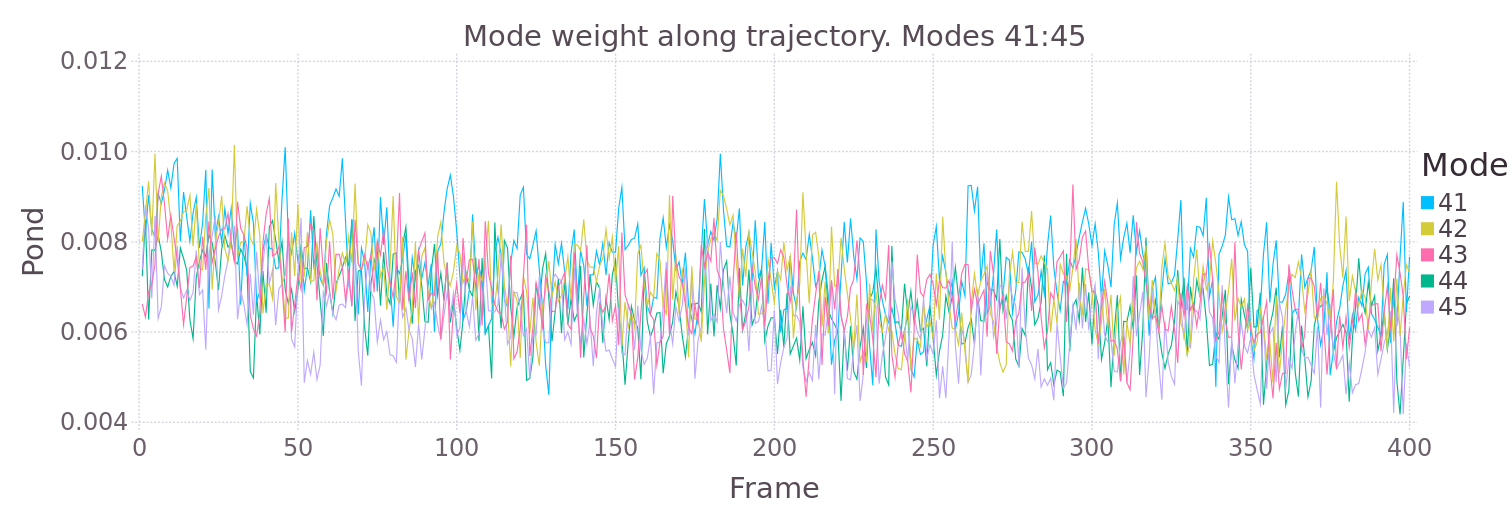

In [116]:
# Compila todo en un dataframe
df_PondMode = DataFrame(Pond = [ PondMode_41; PondMode_42; PondMode_43; PondMode_44; PondMode_45 ],
Mode = repeat(["41"; "42" ; "43"; "44" ; "45" ], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames) ; collect(1:n_frames) ;
    collect(1:n_frames) ; collect(1:n_frames) ])

# Plot
pdf_Wgramm_neq_lf_lb = plot(df_PondMode, x="Frame", y="Pond", color = "Mode", Geom.line,
Guide.title("Mode weight along trajectory. Modes 41:45"),
Guide.xticks(ticks=collect(0:50:400)),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

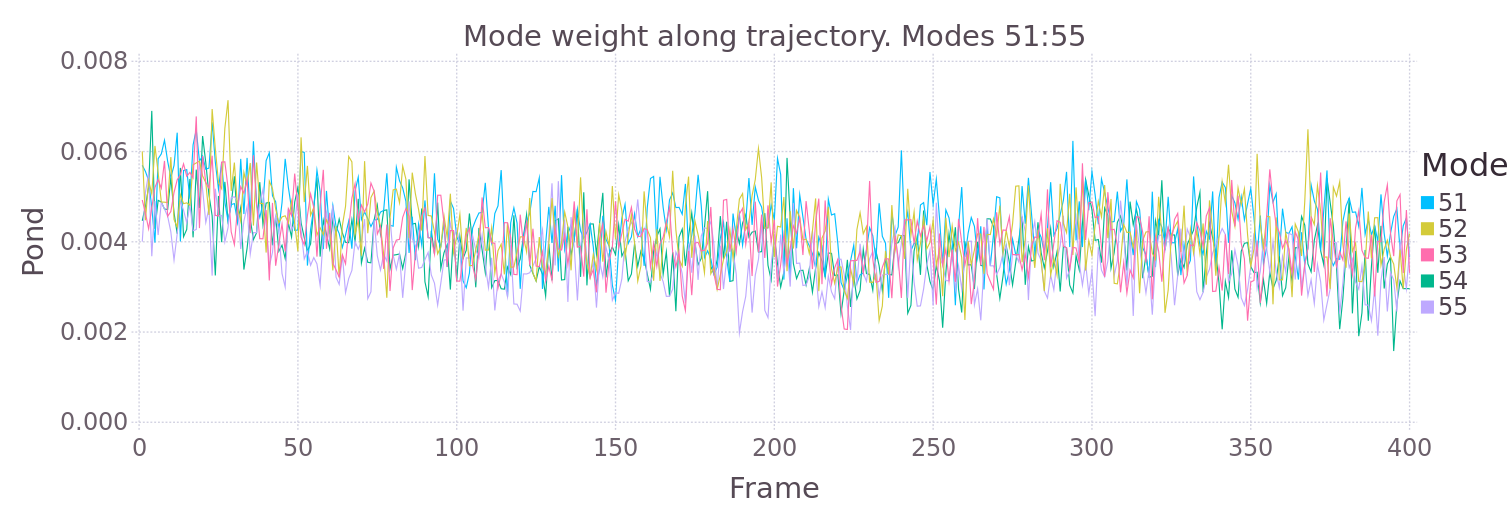

In [112]:
# Compila todo en un dataframe
df_PondMode = DataFrame(Pond = [ PondMode_51; PondMode_52; PondMode_53; PondMode_54; PondMode_55 ],
Mode = repeat(["51"; "52" ; "53"; "54" ; "55" ], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames) ; collect(1:n_frames) ;
    collect(1:n_frames) ; collect(1:n_frames) ])

# Plot
pdf_Wgramm_neq_lf_lb = plot(df_PondMode, x="Frame", y="Pond", color = "Mode", Geom.line,
Guide.title("Mode weight along trajectory. Modes 51:55"),
Guide.xticks(ticks=collect(0:50:400)),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

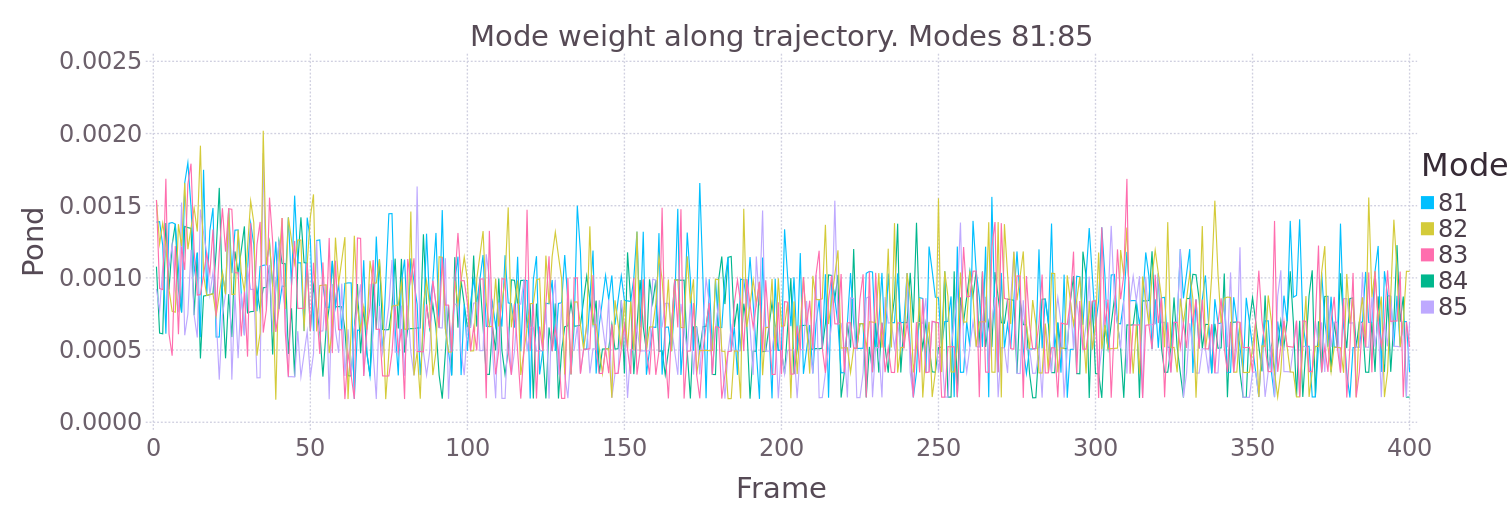

In [114]:
# Compila todo en un dataframe
df_PondMode = DataFrame(Pond = [ PondMode_81; PondMode_82; PondMode_83; PondMode_84; PondMode_85 ],
Mode = repeat(["81"; "82" ; "83"; "84" ; "85" ], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames) ; collect(1:n_frames) ;
    collect(1:n_frames) ; collect(1:n_frames) ])

# Plot
pdf_Wgramm_neq_lf_lb = plot(df_PondMode, x="Frame", y="Pond", color = "Mode", Geom.line,
Guide.title("Mode weight along trajectory. Modes 81:85"),
Guide.xticks(ticks=collect(0:50:400)),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))                               

# Ahora obtengo, p/ c/ frame, una distribución de zeta values a partir de matrices reordenadas de la matriz de modos de no equilibrio

### 1: obtengo las matrices reordenadas. Hacer esto por única vez.